<font color='blue'> **Symple_Ruy_01|03** </font> <font color='red'> **G_RID = Gridgen** </font>

In [ ]:
import os ; import sys ; sys.path.append('../dependencies/') ; import pandas as pd ; import numpy as np ; import matplotlib.pyplot as plt
import shutil ; import flopy ; from flopy.utils.gridgen import Gridgen  ; from flopy.utils.gridintersect import GridIntersect
import shapefile as sf ; from shapely.geometry import Polygon, LineString, MultiLineString, Point # print(f'Flopy version:{flopy.__version__}')
from pathlib import Path ;  import geopandas as gpd ; import earthpy.spatial as es ; import rioxarray as rxr 
from rasterio.plot import plotting_extent ; import earthpy.plot as ep

In [ ]:
sim_ws =  Path("./01_out") ; sim_ws.mkdir(exist_ok=True)  # workspace #bindir  = os.path.join('..','bin') 
ref_data    ='E:\\15_REPOS\\00_data_intern\\Syymple\\sgn_model_1layer' ; datadir  ='E:\\15_REPOS\\00_data_intern\\Syymple\\sgn' 
gridgen_exe = 'gridgen.exe'                                            ;  gridgen_ws = os.path.join(sim_ws, 'gridgen')
exe_name    = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' 
if not os.path.exists(gridgen_ws):  os.makedirs(gridgen_ws)

In [ ]:
Lx=4150. ;Ly=4810. ; xul,yul=1516769.1487, 5033577.7911 ;rot=14 ;delr=delc=50 ;nrow=int(Ly / delc) ;ncol=int(Lx / delr) ; top=1 ;botm=0
ms = flopy.modflow.Modflow(rotation=rot)
dis = flopy.modflow.ModflowDis(ms, nlay=1, nrow=nrow, ncol=ncol, delr=delr,delc=delc, top=top, botm=botm, xul=xul, yul=yul) #dis.botm.plot(colorbar=True, grid=True);
G_RID = Gridgen(dis, model_ws=gridgen_ws, exe_name=gridgen_exe)  ; G_RID.build(verbose=False) #fig = plt.figure(figsize=(4, 4))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')  ; G_RID.plot(ax, linewidth=0.5);

c:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\flopy\utils\gridgen.py:224: UserWarning: Supplying a dis object is deprecated, and support will be removed in version 3.3.7. Please supply StructuredGrid.
  warnings.warn(


<font color='blue'> **geopandas** </font> 

In [5]:
refine_shpfile = os.path.join(datadir, 'shp', 'Quadtree_level.shp')  ; 
refine_shp = sf.Reader(refine_shpfile).shapes()  ; print(f"There are {len(refine_shp)} shapes in the shapefile.")
Path1  = ('E:\\15_REPOS\\00_data_intern\\Syymple\\sgn\\shp')     ; ref2 ='Quadtree_level.shp' 
SHP_path = os.path.join(Path1,ref2)  ; SHP = gpd.read_file(SHP_path)     ; #  SHP.crs 

There are 2 shapes in the shapefile.


In [6]:
refinment_level = 1
for i in refine_shp:
    G_RID.add_refinement_features([i], 'polygon', refinment_level, [0])  ;     refinment_level+=1
G_RID.build(verbose=False)  #fig = plt.figure(figsize=(12, 12))  ; ax = fig.add_subplot(1, 1, 1, aspect='equal')  ; G_RID.plot(ax, linewidth=0.5)

In [7]:
riv_shpfile = os.path.join(datadir, 'shp', 'River_Lambro.shp') ; riv_shp = sf.Reader(riv_shpfile).shapes()
print(f"There are {len(riv_shp)} shapes in the shapefile.")    ; ref2 ='River_Lambro.shp' 
SHP_path = os.path.join(Path1,ref2) ; SHP2 = gpd.read_file(SHP_path) ; SHP2.crs
G_RID.add_refinement_features([riv_shp[0].points], 'line', 1, [0])  ; G_RID.build(verbose=False)
#fig = plt.figure(figsize=(5, 5))           ; ax = fig.add_subplot(1, 1, 1, aspect='equal')
#G_RID.plot(ax, linewidth=0.5) #;flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp','Model_domain.shp')),ax=ax,linewidth=1,alpha=0.5)

There are 1 shapes in the shapefile.


In [ ]:
boundary = sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')).shapes()  ;G_RID.add_active_domain([boundary[0]], [0]) ; G_RID.build(verbose=False)
fig = plt.figure(figsize=(7, 7))       ; ax = fig.add_subplot(1, 1, 1, aspect='equal') ; G_RID.plot(ax, linewidth=0.5)
flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')), ax=ax, linewidth=1, alpha=0.5)

In [9]:
gridprops = G_RID.get_gridprops_disv()     ; model_name = 'sgn'  ; exe_name = 'mf6.exe' 
ncpl = gridprops['ncpl'] ; nvert = gridprops['nvert'] ; vertices = gridprops['vertices'] ; cell2d = gridprops['cell2d'] ; # top, botm, 
nlay = 1 ; nouter = 50 ; ninner = 100 ; hclose = 1e-9 ; rclose = 1e-6
length_units = "METERS"; time_units = 'seconds' ; perioddata = [(1.0, 1, 1.0)]  ; nper= len(perioddata)  ; start_date_time = '2021-06-01' 

In [10]:
sim = flopy.mf6.MFSimulation (exe_name=exe_name,version="mf6", sim_ws=sim_ws, continue_=True)                   #  PEST Use with caution!
tdis = flopy.mf6.ModflowTdis (sim, pname="tdis",nper=nper, perioddata=perioddata, time_units=time_units, start_date_time=start_date_time)
gwf = flopy.mf6.ModflowGwf   (sim,modelname=model_name,save_flows=True, print_flows=True)
ims = flopy.mf6.ModflowIms   (sim, outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,
                              rcloserecord="{} strict".format(rclose))
sim.register_ims_package     (ims, [gwf.name])
disv = flopy.mf6.ModflowGwfdisv   (gwf, nlay=nlay, ncpl=ncpl,length_units=length_units,top=top, botm=botm, nvert=nvert, 
                                   vertices=vertices, cell2d=cell2d,idomain=[1])   #disv.botm.plot()  ; #disv.top.plot()
sim.write_simulation         (silent=True)

<font color='blue'> **Sampling from a raster file** </font> <font color='red'> **top** </font> .. but .. see beta tif x shp first !

In [11]:
raster_file = os.path.join(datadir, 'raster', 'DTM_smooth.tif') ; raster_dem = flopy.utils.Raster.load(raster_file) # ; raster_dem.plot()

EPSG:3003


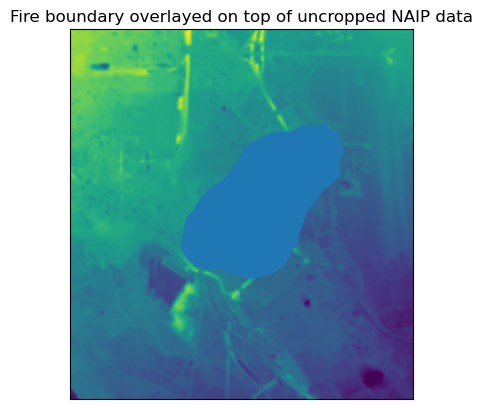

In [12]:
Tif_crs_SHP = es.crs_check(raster_file); print(Tif_crs_SHP)   ; UTMz = SHP.to_crs(Tif_crs_SHP)  ;#  print(UTMz)
Raster_TIF = rxr.open_rasterio(raster_file, masked=True)      ; Raster_ext = plotting_extent(Raster_TIF[0], Raster_TIF.rio.transform())
f, ax = plt.subplots()
ep.plot_rgb(Raster_TIF.values,rgb=[0],ax=ax,title="Fire boundary overlayed on top of uncropped NAIP data",extent=Raster_ext)  
UTMz.plot(ax=ax) ; plt.show()    # refine_shp (sf.Reader) | SHP  (gpd.read_file)  ; riv_shp    (sf.Reader) | SHP2 (gpd.read_file) 

In [13]:
top        = raster_dem.resample_to_grid       (modelgrid=gwf.modelgrid, band=raster_dem.bands[0],method="nearest")    # __________01
print(f'top shape={top.shape}', f'ncpl={ncpl}' )                                                   ; botm = np.ones((nlay, ncpl))  
raster_file_bot1 = os.path.join(datadir, 'raster', 'Bott_L1_fix.tif')  ; raster_bot1 = flopy.utils.Raster.load(raster_file_bot1)
botm[0]    = raster_bot1.resample_to_grid      (modelgrid=gwf.modelgrid,band=raster_bot1.bands[0], method="nearest")   # __________02
disv.top.set_data(top)  ; disv.botm.set_data   (botm)   #disv.top.plot(colorbar=True)  ; disv.botm.plot(colorbar=True)

top shape=(19131,) ncpl=19131


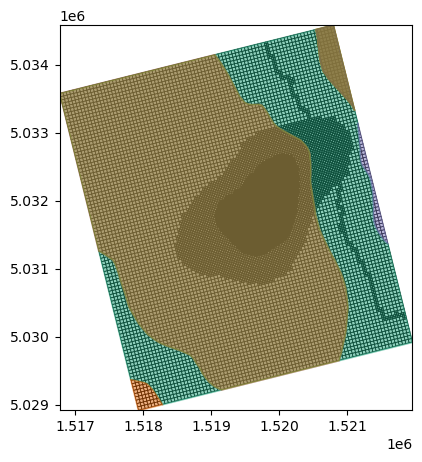

In [15]:
zones_shpfile = os.path.join(datadir, 'shp', 'Geology_250000_clip.shp')
fig = plt.figure(figsize=(5, 5))  ; ax = fig.add_subplot(111, aspect='equal')
G_RID.plot(ax, linewidth=0.5)        ; flopy.plot.plot_shapefile(sf.Reader(zones_shpfile), ax=ax, linewidth=1, alpha=0.5);

In [16]:
zones_records = sf.Reader(zones_shpfile).records() ; print(zones_records)  ; ix = GridIntersect(gwf.modelgrid)
zones_shp = sf.Reader(zones_shpfile).shapes()      ; xx = ix.intersect(zones_shp[0]) ; pd.DataFrame(xx).tail()
#print('x.cellids',x.cellids,disv,'idomain.data',disv.idomain.data)

[Record #0: [301, 'Gravel, sand and silt'], Record #1: [205, 'Gravel and sand']]


,cellids,ixshapes,areas
3591,19126,"POLYGON ((1521750.945827074 5029924.477871884,...",2500.000000
3592,19127,"POLYGON ((1521799.460613438 5029936.573966461,...",2500.000000
3593,19128,"POLYGON ((1521847.975399802 5029948.670061039,...",2500.000000
3594,19129,"POLYGON ((1521896.490186166 5029960.766155616,...",2500.000000
3595,19130,POLYGON ((1521955.8676949039 5029924.039949606...,2436.774504


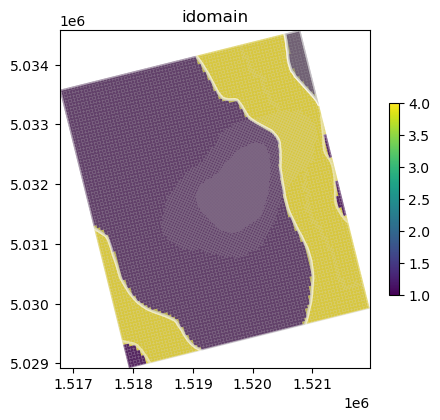

In [17]:
aa = disv.idomain.data[0]               # caution ... number / size of records to intercept 
for i in range(len(zones_shp)):         # add selection criteria (i.e. minimum % of cell area or something like that)
    shp = zones_shp[i]         ; geo_code = zones_records[i][0]
    if geo_code == 301:
        x = ix.intersect(shp).cellids.astype(int)   ; aa[x] = 4         # alluviums zone 4 (301), gravels to zone 1 (205)

disv.idomain.set_data(aa, layer=0)

fig = plt.figure(figsize=(5, 5))
disv.idomain.plot(colorbar=True, mflay=0)  
flopy.plot.plot_shapefile(sf.Reader(zones_shpfile), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3)

In [18]:
strt = 50 ; strt = [50,10,0] ; strt = nlay*[top]                           # print(np.unique(k)) ; npf.k.plot(colorbar=True)
ic   = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)                              # k[k==2] = 1E-08 ; #k[k==3] = 2.3E-3         
k    = disv.idomain.data.copy().astype('float') ; print(k)                             ; k[k==1] = 2.3E-3 ; k[k==4] = 4.5E-3  
npf  = flopy.mf6.ModflowGwfnpf(gwf, k=k, save_flows=True, save_specific_discharge=None , k33=0.1, k33overk=True)  
npf.set_all_data_external()

[[1. 1. 1. ... 4. 4. 4.]]


In [19]:
sim.write_simulation(silent=True) ; # os.listdir(sim_ws)

In [21]:
rch_shpfile = os.path.join(datadir, 'shp', 'Recharge_4.shp')  ; rch_shp = sf.Reader(rch_shpfile).shapes()  ; G_RID.get_area() ; 
#print(sf.Reader(rch_shpfile).record())                        
xmin,xmax=disv.vertices.array['xv'].min(),disv.vertices.array['xv'].max(); ymin,ymax=disv.vertices.array['yv'].min(),disv.vertices.array['yv'].max()
bbox = Polygon(shell=[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])  ; bbox = ix.intersect(bbox) ; cell_areas = bbox.areas
if ncpl == cell_areas.shape:
    print("I think we got'em all cap'n!")  #Polygon(shell=model_vertices_xy, holes=[])
cell_areas

I think we got'em all cap'n!


array([2500.00000002, 2500.00000001, 2500.00000001, ..., 2500.00000001,
       2500.00000001, 2500.00000002])

In [22]:
spd_rch = []  ;   read_recharge = sf.Reader(rch_shpfile)       ; tot_recharge = 0
for i in range(len(rch_shp)):
    shp = rch_shp[i]           ; rch_rate = read_recharge.record(i)[-1]/1000/365/24/60/60          ; intersect = ix.intersect(shp)
    for cellix in intersect:
        icpl = cellix.cellids  ; cellarea = cellix.areas       ; totarea  = cell_areas[icpl]       ; mult = cellarea/totarea
        spd_rch.append(((0, icpl), rch_rate, mult, 'rch'))     ; tot_recharge += (rch_rate * cellarea)

rch = flopy.mf6.ModflowGwfrch(gwf, filename='{}.rch'.format(model_name), pname='rch', auxiliary='MULTIPLIER', auxmultname='MULTIPLIER', 
                              boundnames=True,print_input=True, print_flows=True, save_flows=True,stress_period_data=spd_rch, maxbound=84)
rch_obs = {('rch.csv'): [('rch', 'RCH', 'rch')]}                     ; rch.obs.initialize(digits=9, print_input=False, continuous=rch_obs)
rch.set_all_data_external() ; print(f'Recharge: {tot_recharge} m3/s')            ; print(f'Recharge: {tot_recharge * 60*60*24*365} m3/yr')

Recharge: 0.06744768417791445 m3/s
Recharge: 2127030.1682347106 m3/yr


In [23]:
riv_shpfile = os.path.join(datadir, 'shp', 'River_stages_polyline.shp')  ; read_riv_shp=sf.Reader(riv_shpfile) ; riv_shapes = read_riv_shp.shapes()
riv_spd=[]
for i in range(len(riv_shapes)):
    shp = riv_shapes[i]  ; stage = read_riv_shp.record(i)[0] - 0.4 ; cellids = ix.intersect(shp).cellids ; cond = 0.001 ; rbot = stage - 1.0
    for icpl in cellids:         riv_spd.append(((0, icpl), stage, cond, rbot, 'riv')) #[cellid, stage, cond, rbot, aux, boundname]
riv     = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, boundnames=True)
riv_obs = { ('riv.csv'):[('riv', 'RIV', 'riv')]} ; 
riv.obs.initialize(digits=9, print_input=False,continuous=riv_obs)  ; riv.set_all_data_external()

In [24]:
drnspd = {}  ; drnspd_i = []    # all top cells as drn to avoid floding 
for i in range(ncpl):
    drnu_spd = [(0, i), gwf.dis.top.get_data()[i], 10000, 'surf-drn']  ; drnspd_i.append(drnu_spd)
drnspd[0] = drnspd_i
drn = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drnspd, boundnames=True)
drn_obs = { ('drn_surf.csv'):[('surf-drn', 'DRN', 'surf-drn')]}
drn.obs.initialize(digits=9, print_input=False,continuous=drn_obs)

In [25]:
wel_shpfile = os.path.join(datadir, 'shp', 'wells.shp')  ; read_wel_shp=sf.Reader(wel_shpfile) ; wel_shapes = read_wel_shp.shapes()
wel_spd=[] ; wel_obs_list=[]
for i in range(len(wel_shapes)):
    shp = wel_shapes[i]    ; record = read_wel_shp.record(i) ; pump_rate = record[-1] 
    well_id = record[0]    ; top_lay = record[3]-1           ; bot_lay = record[4]-1
    if top_lay==0:
        wel_obs_list.append((f'well-{well_id}', 'WEL', f'well-{well_id}'))     ; cellids = ix.intersect(shp).cellids
        for icpl in cellids:  wel_spd.append(((0, icpl), pump_rate, f'well-{well_id}'))  #[cellid, stage, cond, rbot, aux, boundname]
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, boundnames=True)
wel_obs = {('wells.csv'): wel_obs_list}                           ; wel.obs.initialize(digits=9, print_input=True, continuous=wel_obs)

In [26]:
boundary_points = sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')).shape(0).points
boundary_line = LineString(boundary_points) ; ix_boundary = ix.intersect(boundary_line.buffer(25,  resolution=4))
raster_file = os.path.join(datadir, 'raster', 'heads_sep2019.asc')  ; raster_heads = flopy.utils.Raster.load(raster_file) ; #raster_heads.plot();

In [27]:
head = raster_heads.resample_to_grid(modelgrid=gwf.modelgrid,band=raster_heads.bands[0], method="nearest")
ghb_spd =[]  ; ghb_obs_list=[]  ; ghb_obs = {('ghb.csv'):ghb_obs_list}
for icpl in ix_boundary.cellids:   
    cond = 100.0
    for layer in [0]:
        ghb_spd.append([(layer, icpl), head[icpl], cond, f'GHB{layer+1}'])     ;ghb_obs_list.append((f'GHB{layer+1}', 'GHB', f'GHB{layer+1}'))
ghb = flopy.mf6.ModflowGwfghb(model=gwf, stress_period_data=ghb_spd, boundnames=True)  
ghb.obs.initialize(digits=9, print_input=True, continuous=ghb_obs)  ; ghb.set_all_data_external()  

In [29]:
obs_shpfile = os.path.join(datadir, 'shp', 'Target_L1_Jan2020.shp') ; read_obs_shp=sf.Reader(obs_shpfile) ; obs_shapes = read_obs_shp.shapes()
obs_list=[]
for i in range(len(obs_shapes)):
    shp = obs_shapes[i] ; cellids = ix.intersect(shp).cellids ; record = read_obs_shp.record(i) ; piezid = record[0]
    for icpl in cellids:
        obs_list.append((f'{piezid}', 'HEAD', (0, icpl))) # assume layer 1
obs_recarray = {'head_obs.csv':obs_list}
obs_package = flopy.mf6.ModflowUtlobs(gwf, digits=10, print_input=True,continuous=obs_recarray)
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbb'.format(model_name),head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,'DIGITS', 6, 'GENERAL')],saverecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'), ('BUDGET', 'ALL')])

In [30]:
sim.write_simulation(silent=True)

In [31]:
sim.run_simulation(silent=True)

(True, [])

In [41]:
mf_list = flopy.utils.Mf6ListBudget(os.path.join(sim_ws, f"{gwf.name}.lst"), timeunit='seconds') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget() ; incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017") 
inc1=pd.DataFrame(incrementaldf) ; inc1.to_csv(sim_ws/"01.2_BUD_incremental.csv"); incrementaldf

,WEL_IN,DRN_IN,RIV_IN,GHB_IN,RCH_IN,TOTAL_IN,WEL_OUT,DRN_OUT,RIV_OUT,GHB_OUT,RCH_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2017-01-09 00:00:01,0.1288,0.0,0.7882,0.7738,0.067448,1.7582,0.3248,0.1993,0.002163,1.232,0.0,1.7582,-1.168200e-07,-0.0


In [33]:
fname = os.path.join(sim_ws, model_name + '.hds') ; hdobj = flopy.utils.HeadFile(fname, model=gwf) ; head = hdobj.get_alldata()
hdtimes = hdobj.get_times() ; hdtimes
hmin = head.min() ; hmax = head.max() ; print(f'Max head : {hmax}' , f'Min head : {hmin}', 'head.shape : ', head.shape)

Max head : 103.02477751845333 Min head : 97.08266057923092 head.shape :  (1, 1, 1, 19131)


In [34]:
hdobj.to_shapefile(os.path.join(sim_ws, "sim-heads.shp"))

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


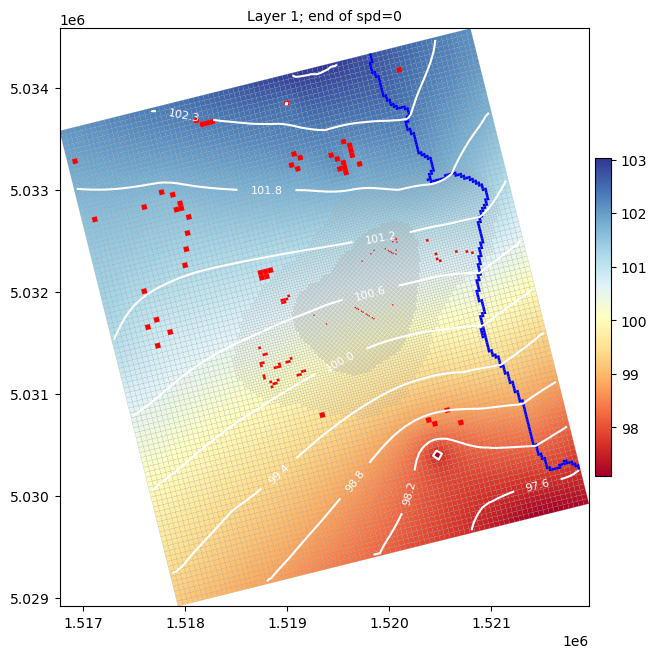

In [ ]:
cint = (hmax-hmin)/10  ; lims = [hmin, hmax]
fig = plt.figure(figsize=(20, 20), tight_layout=True)  ; x = 1
for timestep in range(0, head.shape[0]):
    for i in range(nlay):
        ax = fig.add_subplot(3, 3, x, aspect='equal', sharex=ax, sharey=ax)  ; x+=1
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
        h = mm.plot_array(edgecolor='grey', a=head[timestep,i, 0, :], cmap='RdYlBu', alpha=1, vmin=hmin, vmax=hmax, linewidth=0.1)
        cb = plt.colorbar(h, shrink=0.5, pad=0.01) ; riv=mm.plot_bc("RIV", color="blue") ; riv = mm.plot_bc("GHB", color = 'red')
        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint) ; cs = mm.contour_array(head[timestep,i, 0, :], colors='white', levels=levels)
        plt.clabel(cs, fmt='%.1f', colors='white', fontsize=8) ; wells = mm.plot_bc("WEL")
        t = ax.set_title('Layer {}; end of spd={}'.format(i + 1,timestep), fontsize=10)